# Visualising Stage Surfaces

The stages data provides information about stage surface types, both as percentages of each surface type per stage, as well as a breakdown of surface type for different sections of each stage.

Each stage is also split into *sectors*, where the sector represents the lengths of liaison stages associated with a competitive stage, as well the competitive stage sector information.

In [4]:
# Load in required packages
import seaborn as sns
import matplotlib.pyplot as plt

#%matplotlib inline

In [5]:
from dakar_rallydj.getter import DakarAPIClient

dakar = DakarAPIClient(
    use_cache=True,
    backend='memory',
    # cache_name='dakar_cache',
    expire_after=3600  # Cache for 1 hour
)

In [6]:
# Load in the data from the Dakar live data site

stages_df, sectors_df, stage_surfaces_df, section_surfaces_df, surfaces_df = dakar.get_stages()

## Liaison stage details

Provide a quick overview of the lengths of liaison stages associated with each competitive stage.

In [7]:
# Rename the 0P000 stage to 00000 to make a simpler sort...
sectors_df.loc[sectors_df['code'].str.startswith('0P'), 'stage_code'] = '00000'

sectors_df.sort_values(["stage_code", "sector_number"], inplace=True)
sectors_df.reset_index(drop=True, inplace=True)

sectors_df[["stage_code", "code", "sector_number", "length", "type"]].head()

,stage_code,code,sector_number,length,type
0,00000,0P100,1,26,LIA
1,00000,0P200,2,29,SPE
2,00000,0P300,3,24,LIA
3,01000,01100,1,86,LIA
4,01000,01200,2,413,SPE


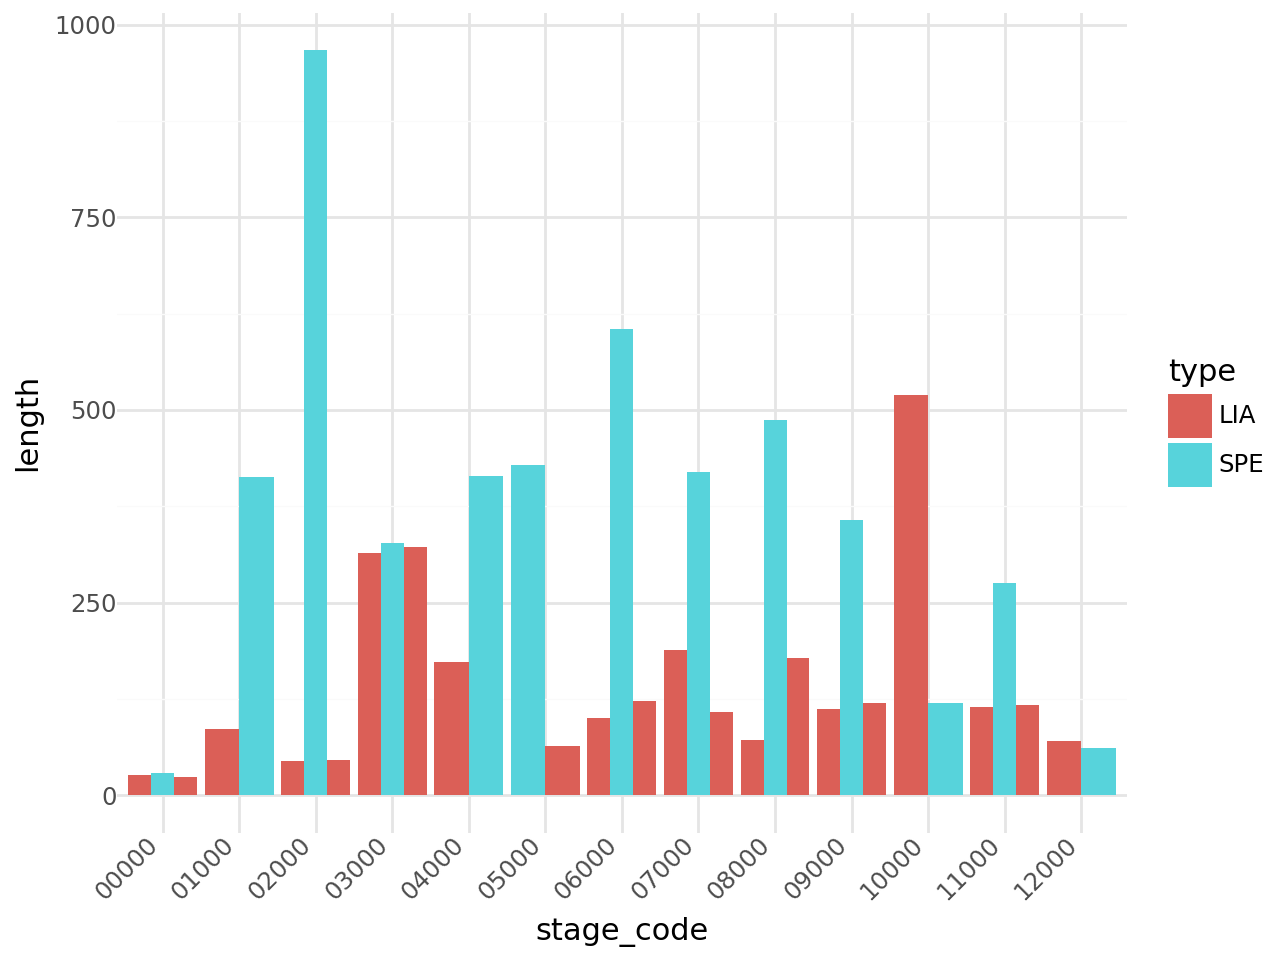

In [8]:
from plotnine import ggplot, aes, geom_bar, theme_minimal, theme, element_text

(
    ggplot(sectors_df, aes(x='stage_code', y='length', fill='type'))
    + geom_bar(stat='identity', position='dodge')  # dodge groups bars
    + theme_minimal()
    + aes(group='sector_number')  # grouping by stage
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

## Percentage distribution of surfaces

Let's start by looking at a dodged bar chart of showing the surface type as a percentage of the length of each stage.

In [9]:
stage_surfaces_df.head()

,code,percentage,color,type
0,01200,18,#753a05,dirt track
1,01200,18,#753a05,dirt track
2,01200,28,#1dc942,gravel track
3,01200,53,#efc07c,sand
4,01200,18,#753a05,dirt track


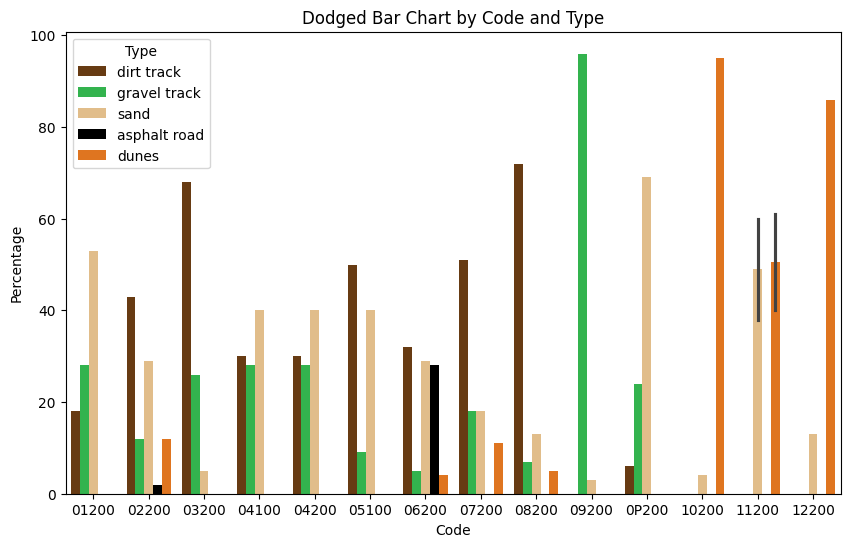

In [10]:
# Mapping types to colors
type_color_map = dict(
    zip(stage_surfaces_df['type'], stage_surfaces_df['color']))

# Create the plot
plt.figure(figsize=(10, 6))

sns.barplot(
    data=stage_surfaces_df,
    x="code",
    y="percentage",
    hue="type",
    palette=type_color_map
)

# Adjust labels and title
plt.title("Dodged Bar Chart by Code and Type")
plt.xlabel("Code")
plt.ylabel("Percentage")
plt.legend(title="Type")
plt.show()

*It looks like the data for stage 4 may be incorrectly mapped onto the liason sector as well as the competitive stage? We could filter that out by checking the sector code maps to a `SPE` sector type in the `sectors_df` dataframe.*

*There is also something strange going on in stage 11 (code `11200`) — it looks as if we are averaging multiple values?*

In [11]:
stage_surfaces_df[stage_surfaces_df["code"]=="11200"]

,code,percentage,color,type
121,11200,60,#efc07c,sand
122,11200,40,#ff7200,dunes
123,11200,38,#efc07c,sand
124,11200,61,#ff7200,dunes


*Ah, it looks like the values may have been incorrectly entered: but which are the correct values?*

In terms of distance, what *distance* is associated with each surface type on each stage?

To find that, we need to multiply the percentage by the distance.

In [12]:
import pandas as pd

stage_surfaces_df = pd.merge(
    sectors_df[["code", "length"]], stage_surfaces_df, on="code")
stage_surfaces_df["distance"] = stage_surfaces_df["length"] * \
    stage_surfaces_df["percentage"]/100

stage_surfaces_df.head()

,code,length,percentage,color,type,distance
0,0P200,29,6,#753a05,dirt track,1.74
1,0P200,29,69,#efc07c,sand,20.01
2,0P200,29,24,#1dc942,gravel track,6.96
3,0P200,29,69,#efc07c,sand,20.01
4,0P200,29,6,#753a05,dirt track,1.74


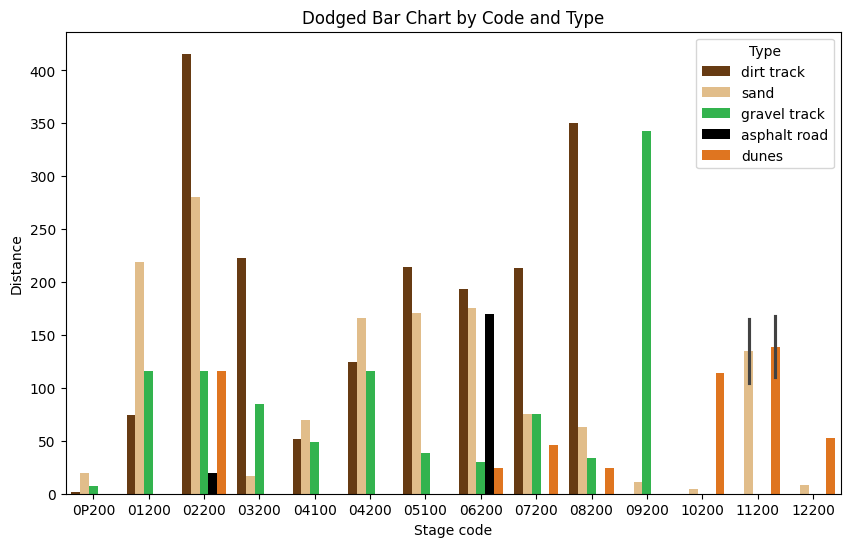

In [13]:
# Create the plot
plt.figure(figsize=(10, 6))

sns.barplot(
    data=stage_surfaces_df,
    x="code",
    y="distance",
    hue="type",
    palette=type_color_map
)

# Adjust labels and title
plt.title("Dodged Bar Chart by Code and Type")
plt.xlabel("Stage code")
plt.ylabel("Distance")
plt.legend(title="Type")
plt.show()

## Stage Section Surfaces

Each competitive stage is split into several sections, of different surface types. For each stage, visualise the stage by section surface type.

In [14]:
section_surfaces_df.head()

,code,section,start,finish,color,type
0,01200,1,0,27,#efc07c,sand
1,01200,2,27,32,#753a05,dirt track
2,01200,3,32,32,#1dc942,gravel track
3,01200,4,32,41,#efc07c,sand
4,01200,5,41,42,#753a05,dirt track


<Figure size 640x480 with 0 Axes>

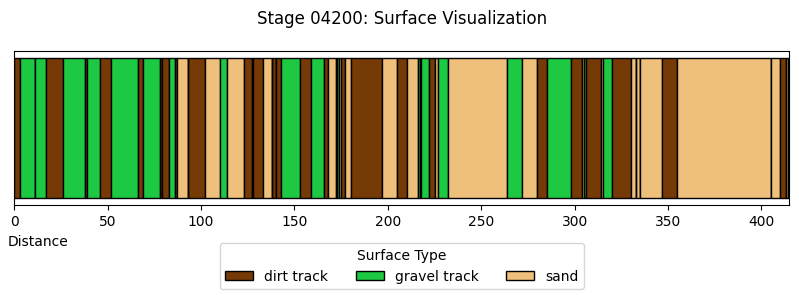

In [15]:
def plot_section_surface_chart(stage_code):
    # Filter data for the selected stage code
    stage_df = section_surfaces_df[section_surfaces_df['code']
                                   == stage_code].sort_values(by='start')

    #CLear plot object
    plt.clf()

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 2))


    # Plot each section as a horizontal bar
    for _, row in stage_df.iterrows():
        ax.barh(
            y=0,  # Single row
            width=row['finish'] - row['start'],  # Bar width is finish - start
            left=row['start'],  # Start position of the bar
            color=row['color'],  # Color based on surface type
            edgecolor='black',
            label=row['type']  # Label for legend
        )

    # Add legend (only unique types)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Surface Type",
              loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

    # Set title and axis labels
    ax.set_title(f"Stage {stage_code}: Surface Visualization", pad=20)
    ax.set_xlabel("Distance", x=0.03)
    ax.set_yticks([])  # Hide y-axis ticks as it's a single row
    # Adjust x-axis limit to max finish value
    ax.set_xlim(
        0, section_surfaces_df[section_surfaces_df['code'] == stage_code]['finish'].max())

    # Show the plot
    #plt.tight_layout()
    plt.show()
    plt.close();


plot_section_surface_chart("04200")

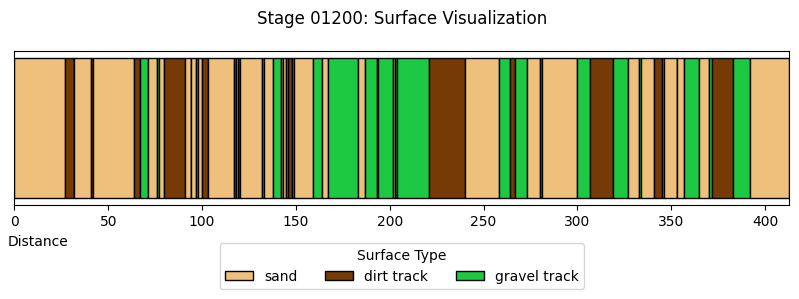

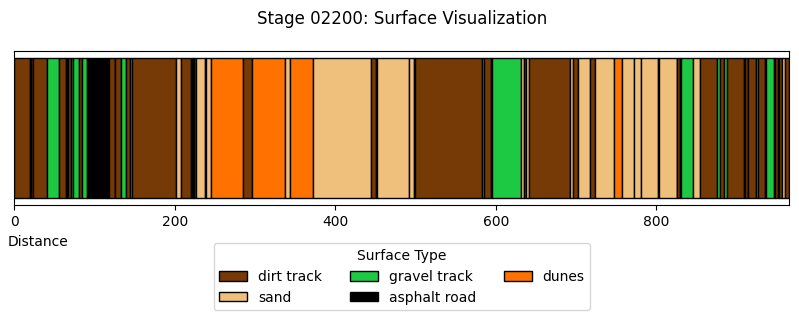

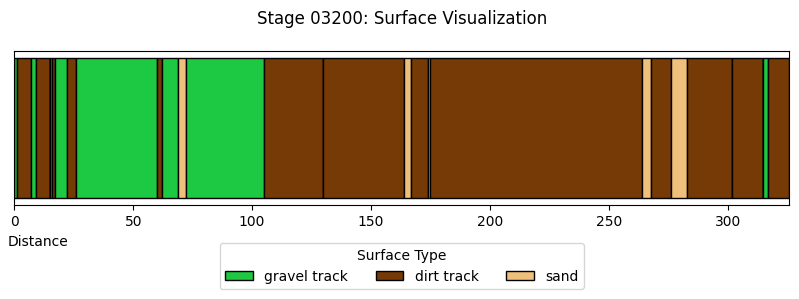

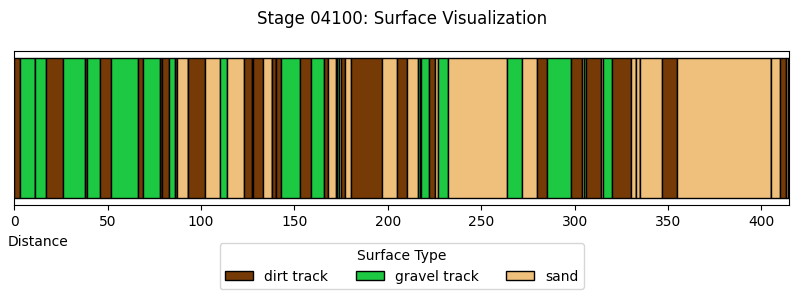

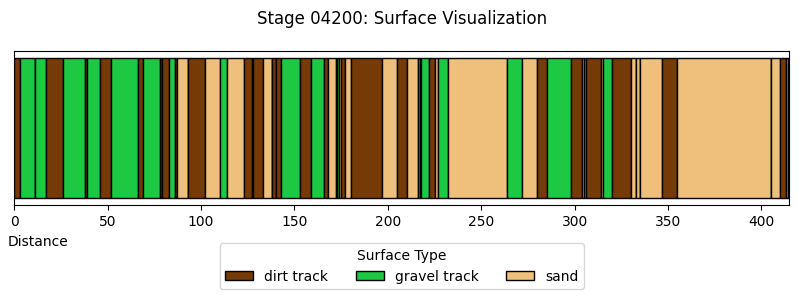

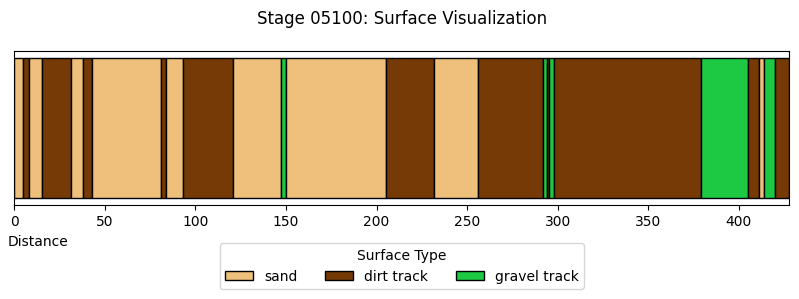

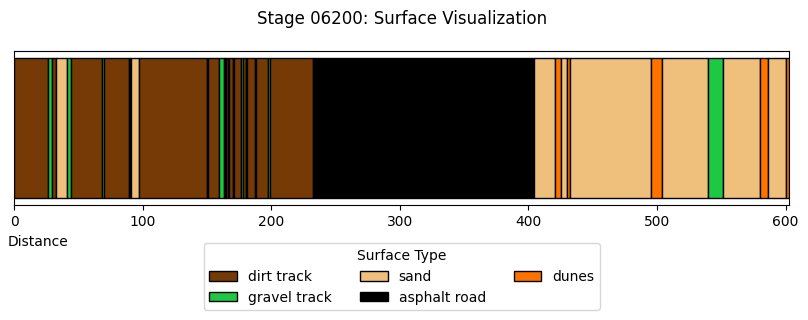

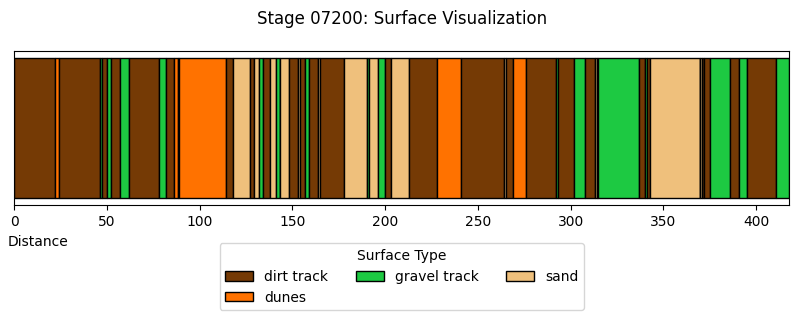

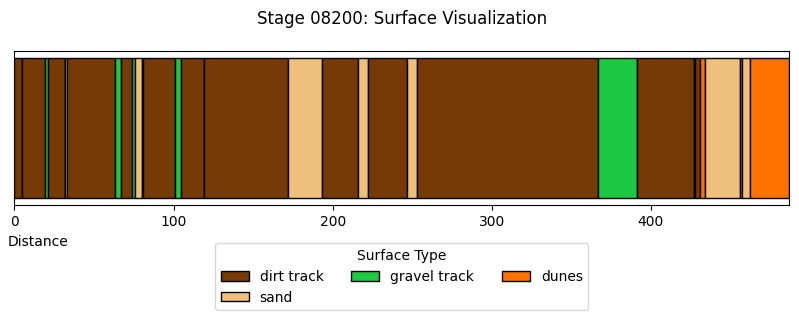

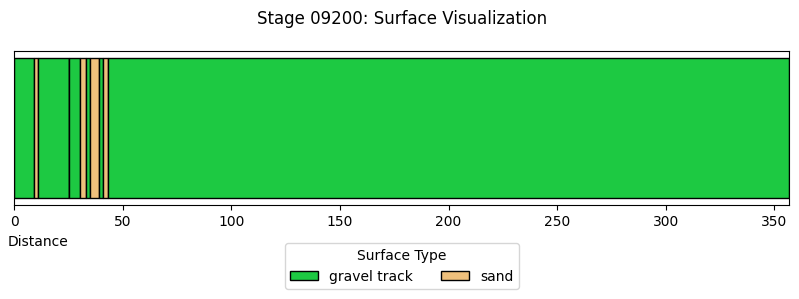

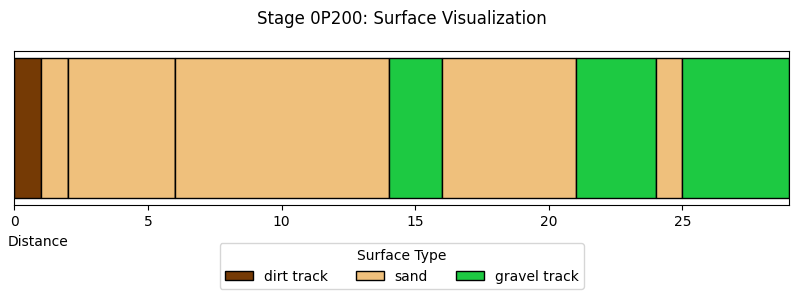

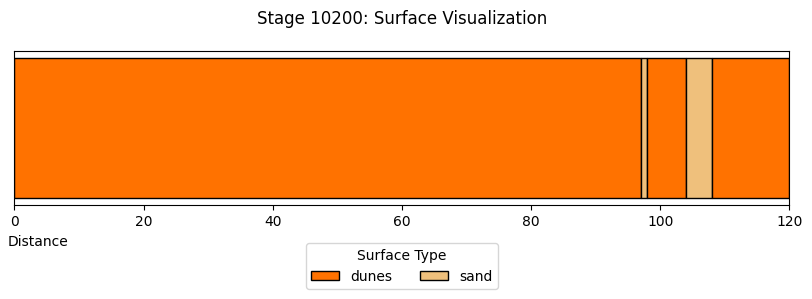

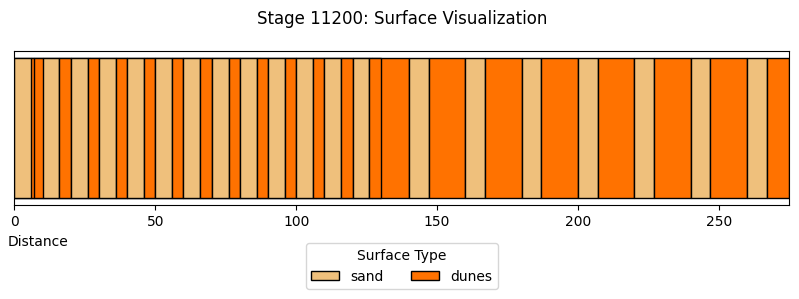

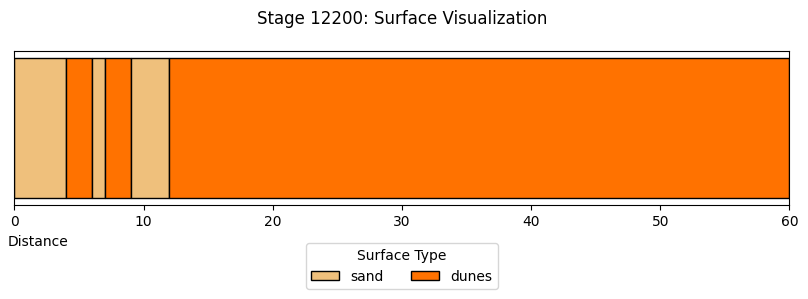

In [16]:
def plot_stage(stage_data):
    """
    Plot a single stage's surface visualization.
    """
    # Extract the stage code
    stage_code = stage_data['code'].iloc[0]

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 2))

    # Plot each section as a horizontal bar using apply
    stage_data.apply(
        lambda row: ax.barh(
            y=0,  # Single row
            width=row['finish'] - row['start'],  # Bar width is finish - start
            left=row['start'],  # Start position of the bar
            color=row['color'],  # Color based on surface type
            edgecolor='black',
            label=row['type']  # Label for legend
        ), axis=1
    )

    # Add legend (only unique types)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Surface Type",
              loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

    # Set title and axis labels
    ax.set_title(f"Stage {stage_code}: Surface Visualization", pad=20)
    ax.set_xlabel("Distance", x=0.03)
    ax.set_yticks([])  # Hide y-axis ticks as it's a single row
    # Adjust x-axis limit to max finish value
    ax.set_xlim(0, stage_data['finish'].max())

    # Show the plot
    #plt.tight_layout()
    plt.show()
    plt.close();


# Group by 'code' and plot each stage
section_surfaces_df.groupby('code')[section_surfaces_df.columns].apply(plot_stage);

# Stage Surface Dashboard

We can use the `ipywidgets` framework to provide us with simple dropdown menu controls to select stages and the percentage or distance associated with each surface type  and then display a surface type chart for just that stage.

*In the HTML book version of this notebook, the dropdown widgets are rendered but the charts are not "live" and will not be updated; ideally, we would integrate something like Thebe-lite so that these charts could be updated as live within the HTML book context.* 

In [17]:
from ipywidgets import interact, widgets

plt.figure(figsize=(10, 6))

def plot_stage_surface_chart(selected_code, typ):
    plt.clf()

    # Filter the DataFrame for the selected code
    filtered_df = stage_surfaces_df[stage_surfaces_df['code'] == selected_code]

    # Create the plot (remove plt.figure() call)
    sns.barplot(
        data=filtered_df,
        x="type",
        y=typ,
        palette=type_color_map,
        hue="type",
        legend=False
    )

    # Adjust labels and title
    plt.title(f"Dodged Bar Chart for Code {selected_code}")
    plt.xlabel("Surface type")
    plt.ylabel(f"{typ.capitalize()}")
    plt.xticks(rotation=45)
    plt.show()
    plt.close();

# Create dropdown widget
code_dropdown = widgets.Dropdown(
    options=stage_surfaces_df['code'].unique(),
    description='Code:',
    value=stage_surfaces_df['code'].unique()[0]
)

typ_dropdown = widgets.Dropdown(
    options=['percentage', 'distance'],  # Add options for Y-axis
    description='Y-axis:',
    value='percentage')

# Interactive plot
interact(plot_stage_surface_chart,
         selected_code=code_dropdown, typ=typ_dropdown);

interactive(children=(Dropdown(description='Code:', options=('0P200', '01200', '02200', '03200', '04100', '042…

In [18]:
# Create dropdown widget
code_dropdown2 = widgets.Dropdown(
    options=stage_surfaces_df['code'].unique(),
    description='Code:',
    value=stage_surfaces_df['code'].unique()[0]
)

_ = interact(plot_section_surface_chart,
         stage_code=code_dropdown2);

interactive(children=(Dropdown(description='Code:', options=('0P200', '01200', '02200', '03200', '04100', '042…